### Working with Rasterio Part 3

In [1]:
import rasterio as rio
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
images_dir = os.path.normpath(r'.\images\rasters')

bands = [file for file in os.listdir(images_dir) if file.endswith(".TIF") ]
bands

# Empty list to store all the files
stack_list = []

for band in bands:
    file = os.path.join(images_dir, band)

    # open the image
    with rio.open(file) as src:
        # read the raster band into an array
        raster_band = src.read(1)
        stack_list.append(raster_band)

# stack all bands
stacked_bands = np.stack(stack_list, axis=0)

bands
stacked_bands



array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

(7731, 7581, 3)


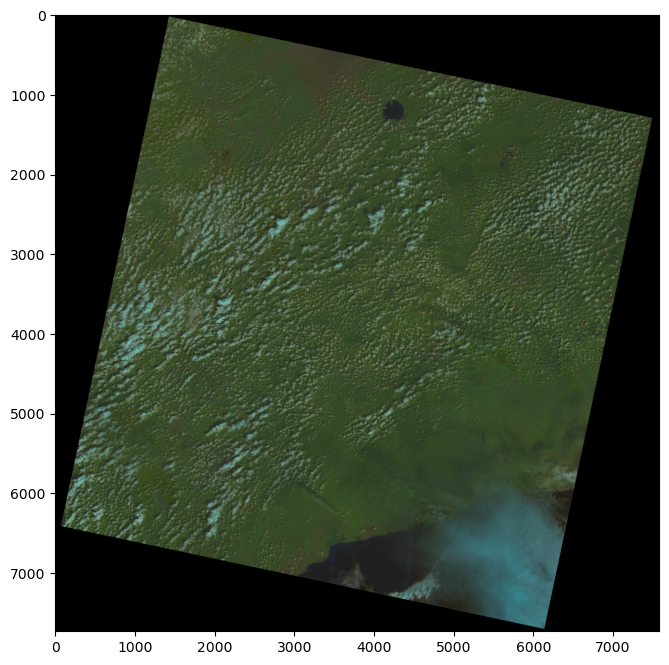

In [3]:
from rasterio.plot import show
red = stacked_bands[5]
green = stacked_bands[4]
blue = stacked_bands[2]

rgb = np.dstack((red, green, blue))

rgb_normalized = (rgb - np.min(rgb)) / (np.max(rgb) - np.min(rgb))
a = np.argmax(rgb)
# print(a)

# show(rgb)

plt.figure(figsize=(8,8))
plt.imshow(rgb_normalized)
print(rgb_normalized.shape)
plt.show()

### Saving Composite Raster

In [4]:
import os
import numpy as np
import rasterio as rio
from rasterio.plot import show

# Load band 1 image
band_1_path = r".\images\rasters\Band1.TIF"
with rio.open(band_1_path) as dataset:
    meta = dataset.meta
    band_1 = dataset.read(1)
    print("Dataset shape is:", band_1.shape)

# Update metadata to reflect the 3-band output
meta.update({
    "count": 3,  # Set to 3 for RGB output
    "dtype": rgb_normalized.dtype  # Make sure the data type matches your normalized array
})

# Specify output path and directory
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)
output_raster = os.path.join(output_dir, "composite.tif")

# Transpose the stacked array to match rasterio's (bands, height, width) requirement
output_data = np.transpose(rgb_normalized, (2, 0, 1))
print("Composite dataset shape is:", output_data.shape)

# Write the normalized RGB data to the output file
with rio.open(output_raster, 'w', **meta) as dst:
    dst.write(output_data)

# Display the output data
show(output_data)


Dataset shape is: (7731, 7581)
Composite dataset shape is: (3, 7731, 7581)


CPLE_AppDefinedError: Deleting output\composite.tif failed: Permission denied

### Reprojecting a raster

In [6]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [7]:
composite_raster = rio.open(r'.\output\composite.tif')
composite_raster.crs

dist_crs = "EPSG:4326"

In [8]:
import os
import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling

# Define paths and destination CRS
source_file = r'.\output\composite.tif'
 

# Open the original image
with rio.open(source_file) as src:
    # Calculate transform and update metadata
    transform, width, height = calculate_default_transform(
        src.crs, dist_crs, src.width, src.height, *src.bounds
    )
    metadata = src.meta.copy()
    metadata.update({
        'crs': dist_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    # Reproject the raster
    output_reprojected = os.path.join(output_dir, "reprojected.tif")

    with rio.open(output_reprojected, 'w', **metadata) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rio.band(src, i),
                destination=rio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dist_crs,
                resampling=Resampling.nearest
            )


In [12]:
projected = rio.open(r'.\output\reprojected.tif')
crs = projected.crs.to_wkt()
print(crs)

GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


### Cropping a raster with a shapefile

In [25]:
import geopandas as gpd
from rasterio.mask import mask as rmask

roi = r"C:\Users\Owner\Desktop\Desktop\12_Days_Geopython_Training\Day 9\output\shp\roi.shp"
composite_path = r"C:\Users\Owner\Desktop\Desktop\12_Days_Geopython_Training\Day 9\output\reprojected.tif"
# composite_path = r"C:\Users\Owner\Desktop\Desktop\12_Days_Geopython_Training\Day 9\images\rasters\Band1.TIF"
clipped_path = os.path.join(output_dir, "clipped.tif")

gdf = gpd.read_file(roi)

with rio.open(composite_path) as src:
    shapes = gdf.geometry

    cropped_image, cropped_image_transform = rmask(src, shapes, crop=True)

    out_meta = src.meta.copy()

    out_meta.update({
        "height": cropped_image.shape[1],
        "width": cropped_image.shape[2],
        "transform": cropped_image_transform
    })
    
    # Save the cropped image
with rio.open(clipped_path, 'w', **out_meta) as dst:
    dst.write(cropped_image)



In [28]:
### Assignment

# package_installed
import geopandas as gpd
from rasterio.mask import mask as rmask

roi = r'./output/shp/roi.shp'

gdf = gpd.read_file(roi)
clipped_path = os.path.join(output_dir, 'clipped_raster.tif')
composite_path = r'.\output\reprojected.tif'

with rio.open(composite_path) as src:
    shape = gdf.geometry

    cropped_image, cropped_image_transform = rmask(src, shape, crop=True)

    output_meta = src.meta.copy()

    output_meta.update({
        'height': cropped_image.shape[1],
        'width': cropped_image.shape[2],
        'transform': cropped_image_transform
    })

# save to the clipped path
with rio.open(clipped_path, 'w', **output_meta) as dst:
    dst.write(cropped_image)



In [37]:
images_dir = os.path.normpath(r'.\images\rasters')

bands = os.listdir(images_dir)
bands

print(bands)

stacked_list = []

for band in bands:
    file = os.path.join(images_dir, band)

    with rio.open(file) as src:
        image = src.read(1)
        stacked_list.append(image)

stacked_list

stacked_bands = np.stack(stacked_list, axis=0)
stacked_bands.shape

['Band1.TIF', 'Band2.TIF', 'Band3.TIF', 'Band4.TIF', 'Band5.TIF', 'Band6.TIF', 'Band7.TIF']


(7, 7731, 7581)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


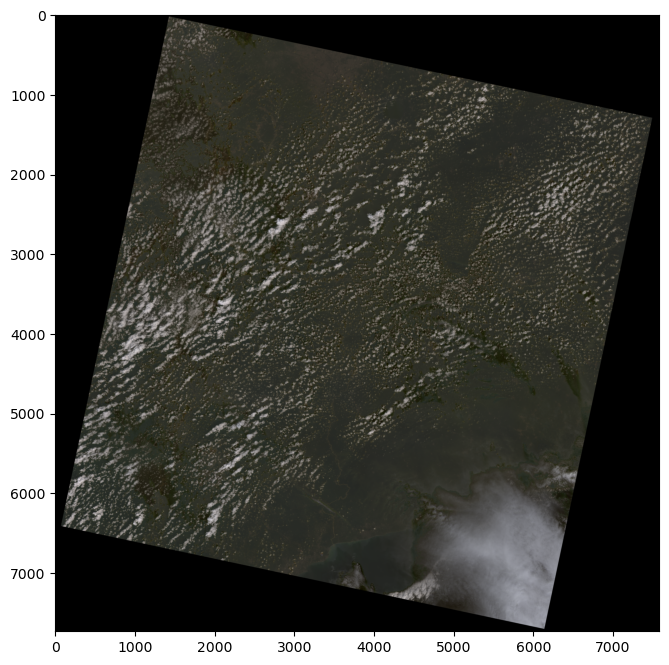

In [6]:
red = stacked_bands[3]
green = stacked_bands[2]
blue = stacked_bands[1]

true_colour = np.dstack((red, green, blue))

true_colour = (true_colour - np.min(true_colour)) / (np.max(true_colour) - np.min(true_colour))


## saving to a new file
with rio.open(band_1_path ) as src:
    meta = src.meta

    meta.update({
        "count": 3,  # Set to 3 for RGB output
    "dtype": "float32"
    })

output_path = os.path.join(output_dir, 'true_colour.tif')

# to match rasterio format
true_colour_transpose = np.transpose(true_colour, (2,0,1))
print(true_colour_transpose)

# save to an output file
with rio.open(output_path, 'w', **meta) as dst:
    dst.write(true_colour_transpose)

plt.figure(figsize=(8,8))
plt.imshow(true_colour)
plt.show()